<a href="https://colab.research.google.com/github/ADRIANVM117/data-science-portfolio/blob/main/GE_STOCK_STATS_AND_PREDICTIVE_MODEL/Backtesting_GE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Pasos Detallados para Implementar Backtesting Usando LSTM, MGBM con Volatilidad Estocástica y el Modelo de Heston
El objetivo del backtesting es evaluar cómo habría funcionado nuestra estrategia en el pasado utilizando nuestras herramientas de predicción y simulación.

🔹 FASE 1: Preparación de Datos
- 1️⃣ Definir el período de backtesting:

Seleccionar una ventana de tiempo histórica (ejemplo: 1 mes de datos en intervalos de 30 minutos).
Dividir los datos en bloques deslizantes (rolling windows) para simular decisiones en diferentes momentos del pasado.
- 2️⃣ Construir la ventana de predicción:

Para cada punto en el tiempo, tomar los últimos N datos como entrada de la LSTM y generar una predicción.
Guardar la predicción y el precio real 30 minutos después para evaluar la precisión.

🔹 FASE 2: Generación de Predicciones y Simulaciones
- 3️⃣ Ejecutar la LSTM en cada punto del backtesting:

Usar el modelo entrenado de LSTM para predecir el precio en los próximos 30 minutos.
Guardar la predicción en un DataFrame junto con el precio real observado.
- 4️⃣ Ejecutar el MGBM con Volatilidad Estocástica:

Simular múltiples trayectorias futuras del precio durante 5 pasos de 30 minutos.
Guardar la mediana y los intervalos de confianza (percentil 5%-95%).
Comparar la predicción de la LSTM con la mediana de la simulación.
- 5️⃣ Calcular la Volatilidad con el Modelo de Heston:

Estimar la volatilidad futura para los próximos 5 pasos de 30 minutos.
Evaluar si la volatilidad es alta o baja.
Guardar la evolución de la volatilidad en el tiempo.

🔹 FASE 3: Aplicación de Estrategia de Trading
- 6️⃣ Definir Reglas de Entrada y Salida:

Compra (posición larga):
Si la LSTM predice un aumento del precio y la mediana del MGBM también es creciente con baja dispersión.
Si la volatilidad del modelo de Heston es baja, se confirma la entrada.
Venta en corto (posición corta):
Si la LSTM predice una caída del precio y la mediana del MGBM también muestra tendencia bajista con baja dispersión.
Si la volatilidad es baja, se confirma la entrada en corto.
Evitar operar si hay alta dispersión:
Si el percentil 5%-95% del MGBM es muy amplio, la incertidumbre es alta y se evita operar.

🔹 FASE 4: Evaluación de Resultados
- 7️⃣ Ejecutar la estrategia en cada punto del backtesting:

Simular cada decisión y registrar el precio de entrada y salida.
Evaluar el rendimiento basado en las reglas definidas.
- 8️⃣ Calcular métricas clave para evaluar el desempeño:

Retorno sobre la inversión (ROI) → ¿Cuánto se habría ganado o perdido?
Drawdowns → ¿Cuál fue la mayor caída en el portafolio?
Porcentaje de aciertos → ¿Cuántas veces la estrategia acertó la dirección del precio?
Sharpe Ratio → Medida del rendimiento ajustado por riesgo.
Comparación con el mercado → ¿El modelo supera un enfoque de "buy & hold"?

🔹 FASE 5: Visualización y Análisis de Resultados
- 9️⃣ Graficar los resultados del backtesting:

Comparar las predicciones de la LSTM con el precio real.
Superponer las simulaciones del MGBM sobre los precios reales.
Mostrar la volatilidad del modelo de Heston en el tiempo.
Visualizar las decisiones de compra y venta en el gráfico.

# <b>FASE 1: PREPARACIÓN DE DATOS </b>

In [104]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df_final_1 = pd.read_csv('/content/drive/MyDrive/df_final.csv')
df_final_1.set_index('Unnamed: 0', inplace=True)
df_final_1
# descargar el df_final


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2025-01-06 08:30:00,172.56,173.20,171.96,173.200,40423.0,172.9510,172.764180,0.186820,1.24,0.830764,...,171.18,80.800000,0.004145,172.786667,49.159138,172.748972,172.690820,0.058152,0.033490,226649.785714
2025-01-06 09:00:00,173.15,173.20,171.94,172.140,5265.0,172.9360,172.667331,0.268669,1.26,0.780407,...,171.18,38.400000,-0.004914,172.426667,-46.985711,172.666967,172.650086,0.016882,0.027324,281875.571429
2025-01-06 09:30:00,173.15,173.15,171.18,172.530,518129.0,172.9090,172.784515,0.124485,1.97,0.880407,...,171.00,57.089552,-0.001389,172.286667,-89.533333,172.762780,172.690892,0.071887,0.029935,418405.714286
2025-01-06 10:00:00,172.52,173.68,172.38,173.680,374817.0,172.9970,172.841074,0.155926,1.30,0.879693,...,171.00,100.000000,0.007483,173.246667,183.150750,172.805103,172.703764,0.101339,0.019447,399894.214286
2025-01-06 10:30:00,173.62,173.68,172.69,172.735,245625.0,173.0225,172.654646,0.367854,0.99,0.876121,...,171.00,64.738806,-0.001301,173.035000,169.587738,172.646031,172.625665,0.020366,-0.001026,373126.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 18:30:00,202.18,202.49,201.51,201.530,919468.0,201.7853,201.984463,-0.199163,0.98,0.000000,...,0.00,0.000000,0.000000,201.843333,0.000000,202.009704,202.085213,-0.075508,-0.020335,0.000000
2025-02-04 19:00:00,202.18,202.18,201.51,201.750,919466.0,201.7303,202.085455,-0.355155,0.67,0.000000,...,0.00,0.000000,0.000000,201.813333,0.000000,202.096923,202.129630,-0.032707,-0.006541,0.000000
2025-02-04 19:00:00,202.18,202.18,201.51,201.750,919466.0,201.7303,202.085455,-0.355155,0.67,0.000000,...,0.00,0.000000,0.000000,201.813333,0.000000,202.096923,202.129630,-0.032707,-0.006541,0.000000


## MIN-MAX()

In [105]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar el escalador
scaler = MinMaxScaler()

# Escalar todas las columnas
df_final = pd.DataFrame(scaler.fit_transform(df_final_1), columns=df_final_1.columns, index=df_final_1.index)

# Ahora usar df_scaled en lugar de df_final
df_final

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2025-01-06 08:30:00,0.083607,0.079861,0.349943,0.094199,0.007021,0.072750,0.066653,0.740084,0.029552,0.138163,...,0.832709,0.808000,0.521597,0.075451,0.619118,0.064809,0.050302,0.712087,0.704581,0.206434
2025-01-06 09:00:00,0.099781,0.079861,0.349559,0.064917,0.000914,0.072327,0.063914,0.744884,0.030029,0.129788,...,0.832709,0.384000,0.488672,0.065465,0.438996,0.062484,0.049115,0.703976,0.703160,0.256734
2025-01-06 09:30:00,0.099781,0.078526,0.334994,0.075691,0.090000,0.071566,0.067228,0.736428,0.046949,0.146419,...,0.831833,0.570896,0.501482,0.061581,0.359286,0.065200,0.050304,0.714787,0.703762,0.381086
2025-01-06 10:00:00,0.082511,0.092682,0.357992,0.107459,0.065106,0.074048,0.068827,0.738272,0.030982,0.146300,...,0.831833,1.000000,0.533728,0.088211,0.870142,0.066400,0.050679,0.720575,0.701345,0.364226
2025-01-06 10:30:00,0.112664,0.092682,0.363933,0.081354,0.042665,0.074767,0.063556,0.750701,0.023594,0.145706,...,0.831833,0.647388,0.501802,0.082339,0.844733,0.061891,0.048404,0.704661,0.696626,0.339845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 18:30:00,0.895559,0.862179,0.916251,0.876796,0.159713,0.886130,0.892932,0.717447,0.023356,0.000000,...,0.000000,0.000000,0.506531,0.881461,0.527021,0.894268,0.906605,0.685818,0.692176,0.000000
2025-02-04 19:00:00,0.895559,0.853900,0.916251,0.882873,0.159713,0.884578,0.895787,0.708299,0.015968,0.000000,...,0.000000,0.000000,0.506531,0.880629,0.527021,0.896740,0.907898,0.694230,0.695355,0.000000
2025-02-04 19:00:00,0.895559,0.853900,0.916251,0.882873,0.159713,0.884578,0.895787,0.708299,0.015968,0.000000,...,0.000000,0.000000,0.506531,0.880629,0.527021,0.896740,0.907898,0.694230,0.695355,0.000000


 # **Fase 2: Entrenamiento y Validación del LSTM**

## **LSTM**

Epoch 1/50 - Train Loss: 0.088851, Val Loss: 0.008193
Epoch 2/50 - Train Loss: 0.007007, Val Loss: 0.002684
Epoch 3/50 - Train Loss: 0.005029, Val Loss: 0.001892
Epoch 4/50 - Train Loss: 0.003268, Val Loss: 0.001266
Epoch 5/50 - Train Loss: 0.002516, Val Loss: 0.002891
Epoch 6/50 - Train Loss: 0.002062, Val Loss: 0.001187
Epoch 7/50 - Train Loss: 0.001714, Val Loss: 0.000808
Epoch 8/50 - Train Loss: 0.001665, Val Loss: 0.000780
Epoch 9/50 - Train Loss: 0.001846, Val Loss: 0.002350
Epoch 10/50 - Train Loss: 0.001594, Val Loss: 0.001233
Epoch 11/50 - Train Loss: 0.001520, Val Loss: 0.000833
Epoch 12/50 - Train Loss: 0.001567, Val Loss: 0.000726
Epoch 13/50 - Train Loss: 0.001564, Val Loss: 0.002828
Epoch 14/50 - Train Loss: 0.001638, Val Loss: 0.000737
Epoch 15/50 - Train Loss: 0.001666, Val Loss: 0.001014
Epoch 16/50 - Train Loss: 0.001447, Val Loss: 0.000735
Epoch 17/50 - Train Loss: 0.001452, Val Loss: 0.000749
Epoch 18/50 - Train Loss: 0.001549, Val Loss: 0.000826
Epoch 19/50 - Train

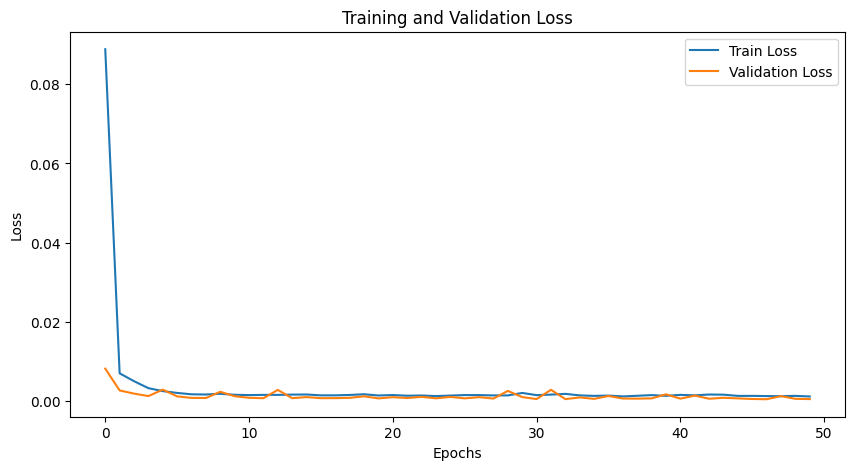

Predicción del precio en los próximos 30 minutos: 201.86
Último precio real (2025-02-04 19:30:00): 202.16
Backtesting RMSE: 0.0254
Backtesting MAE: 0.0184


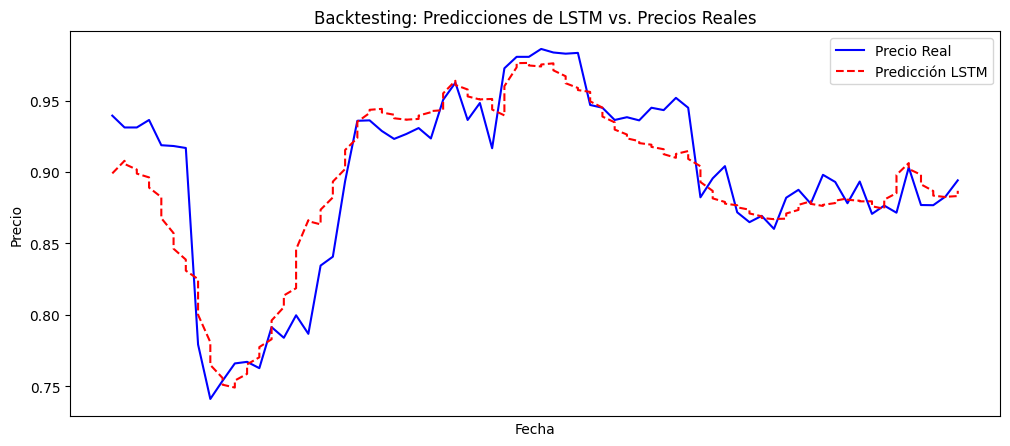

In [126]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 📌 1. Preparación de los Datos (X = Features, Y = Objetivo)
window_size = 30  # Se cambia a 30 minutos

X, Y, timestamps = [], [], []
for i in range(len(df_final) - window_size):
    X.append(df_final.iloc[i:i+window_size].values)  # Todas las columnas como entrada
    Y.append(df_final.iloc[i+window_size]['Close'])  # Solo la columna 'Close' como salida
    timestamps.append(df_final.index[i + window_size])  # Guardar la fecha correspondiente

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

# 📌 2. División en Entrenamiento y Validación
train_split = 0.8
split = int(len(Y) * train_split)

X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]
timestamps_train, timestamps_val = timestamps[:split], timestamps[split:]

# 📌 3. Creación de Datasets para PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Configuración de hiperparámetros
batch_size = 64
learning_rate = 0.003

# Crear datasets y DataLoaders
train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset = TimeSeriesDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# 📌 4. Definir la Arquitectura de la LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=120, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Usamos solo la última salida de la secuencia

# 📌 5. Instanciar y Configurar el Modelo
input_size = X.shape[2]  # Número de características
model = LSTMModel(input_size).to("cpu")

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 📌 6. Entrenamiento de la LSTM
num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            preds = model(X_batch)
            val_loss += criterion(preds.squeeze(), Y_batch).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# 📌 7. Graficar la Pérdida de Entrenamiento y Validación
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


# 📌 8. Hacer Predicción de los Próximos 30 Minutos (con desnormalización)
model.eval()
latest_X = torch.tensor(X[-1], dtype=torch.float32).unsqueeze(0)  # Última secuencia de entrada
predicted_price = model(latest_X).cpu().detach().numpy().flatten()[0]


# 📌 Solución para desnormalizar correctamente
expanded_prediction = np.zeros((1, X.shape[2]))  # Crear un array de ceros con 26 columnas
expanded_prediction[0, 0] = predicted_price  # Insertar el valor predicho en la primera columna

# Desnormalizar correctamente
predicted_price_real = scaler.inverse_transform(expanded_prediction)[0, 0]  # Extraer solo el precio real

print(f"Predicción del precio en los próximos 30 minutos: {predicted_price_real:.2f}")

# 📌 9. Obtener el último precio real del DataFrame
last_real_price_index = df_final_1.index[-1]  # Última fecha y hora registrada
last_real_price = df_final_1.iloc[-1]['Close']  # Último precio real

print(f"Último precio real ({last_real_price_index}): {last_real_price:.2f}")





# 📌 8. Backtesting: Predicciones para cada punto histórico
model.eval()
predictions = []
real_values = []
dates = []

with torch.no_grad():
    for i in range(len(X_val)):
        input_seq = torch.tensor(X_val[i], dtype=torch.float32).unsqueeze(0)
        predicted_value = model(input_seq).cpu().detach().numpy().flatten()[0]

        # Guardar datos para evaluación
        predictions.append(predicted_value)
        real_values.append(Y_val[i])
        dates.append(timestamps_val[i])

# 📌 9. Guardar resultados en un DataFrame
df_backtest_1 = pd.DataFrame({
    "Fecha": dates,
    "Precio Real": real_values,
    "Precio Predicho": predictions
})
df_backtest_1.set_index("Fecha", inplace=True)

# 📌 10. Evaluación del Modelo en Backtesting
rmse = np.sqrt(mean_squared_error(df_backtest_1["Precio Real"], df_backtest_1["Precio Predicho"]))
mae = mean_absolute_error(df_backtest_1["Precio Real"], df_backtest_1["Precio Predicho"])

print(f"Backtesting RMSE: {rmse:.4f}")
print(f"Backtesting MAE: {mae:.4f}")


# 📌 11. Graficar predicciones vs. precios reales (sin mostrar fechas en el eje X)
plt.figure(figsize=(12,5))
plt.plot(df_backtest_1.index, df_backtest_1["Precio Real"], label="Precio Real", color="blue")
plt.plot(df_backtest_1.index, df_backtest_1["Precio Predicho"], label="Predicción LSTM", color="red", linestyle="dashed")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Backtesting: Predicciones de LSTM vs. Precios Reales")
plt.legend()

# 🔹 Ocultar las etiquetas del eje X
plt.xticks([])

plt.show()


## <b>Desescalar df_backtest_1  </b>

In [127]:
# Aplicar la transformación inversa para desescalar los valores
df_backtest_1_descaled = df_backtest_1.copy()  # Crear una copia para no modificar el original

# Crear un array de ceros con el mismo número de columnas que el df_final
expanded_data = np.zeros((df_backtest_1.shape[0], df_final.shape[1]))

# Insertar los valores escalados en la posición correspondiente de la columna 'Close'
expanded_data[:, df_final.columns.get_loc("Close")] = df_backtest_1["Precio Real"]

# Desescalar los valores
descaled_real = scaler.inverse_transform(expanded_data)[:, df_final.columns.get_loc("Close")]

# Repetir el proceso para 'Precio Predicho'
expanded_data[:, df_final.columns.get_loc("Close")] = df_backtest_1["Precio Predicho"]
descaled_predicted = scaler.inverse_transform(expanded_data)[:, df_final.columns.get_loc("Close")]

# Asignar los valores desescalados al DataFrame
df_backtest_1_descaled["Precio Real"] = descaled_real
df_backtest_1_descaled["Precio Predicho"] = descaled_predicted

# Mostrar el DataFrame desescalado
df_backtest_1_descaled


,Precio Real,Precio Predicho
Fecha,,
2025-01-31 16:30:00,203.80,202.336710
2025-01-31 17:00:00,203.50,202.655794
2025-01-31 17:00:00,203.50,202.574604
2025-01-31 17:30:00,203.50,202.433165
2025-01-31 17:30:00,203.50,202.330582
...,...,...
2025-02-04 18:30:00,201.53,201.773571
2025-02-04 19:00:00,201.75,201.736172
2025-02-04 19:00:00,201.75,201.742505


## <b> Ejecución del MGBM con Volatilidad Estocástica </b>

simular múltiples trayectorias futuras utilizando el Movimiento Geométrico Browniano Modificado (MGBM) con Volatilidad Estocástica.

📌 Objetivo:

1. Generar múltiples trayectorias futuras del precio en los siguientes 5 pasos de 30 minutos.
2. Evaluar la mediana y el intervalo de confianza (percentiles 5%-95%).
3. Comparar la predicción de la LSTM con la mediana del MGBM-SV.

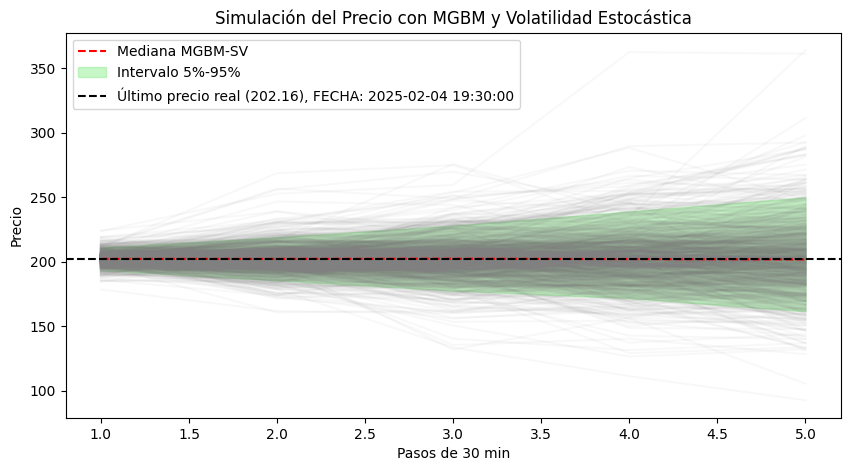

,Mediana,Percentil_5,Percentil_95,Dispersion
Paso,,,,
1,202.174975,193.493575,210.987741,17.494166
2,202.174920,185.543400,218.927838,33.384437
3,202.314358,177.608278,227.957313,50.349035
4,202.003395,171.744164,238.973085,67.228921
5,201.720322,161.586376,249.813156,88.226780


In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 1️⃣ Extraer el último precio real y manejar ceros
close_prices = df_final_1["Close"].values
close_prices[close_prices == 0] = 1e-6  # Evitar división por cero

# 🔹 2️⃣ Calcular rendimientos logarítmicos con manejo de errores
log_returns = np.log(close_prices[1:] / close_prices[:-1])

# 🔹 3️⃣ Estimar parámetros del Modelo de Heston
mu = np.mean(log_returns)  # Drift estimado
sigma = np.std(log_returns)  # Volatilidad estimada
kappa = 2.0  # Tasa de reversión a la media
theta = 0.0001  # Media de la varianza a largo plazo
sigma_v = 0.1  # Volatilidad del proceso de volatilidad
v0 = sigma**2  # Volatilidad inicial

# 🔹 4️⃣ Configuración de la simulación
S0 = df_final_1["Close"].iloc[-1]  # Último precio conocido
last_real_price_index = df_final_1.index[-1]  # Última fecha registrada
n_simulations = 1000  # Número de simulaciones
n_steps = 5  # Pasos futuros de 30 min
dt = 1  # Incremento temporal en unidades de 30 min

# Matriz para almacenar las simulaciones
simulated_prices = np.zeros((n_simulations, n_steps))

for i in range(n_simulations):
    S_t = S0  # Precio inicial
    v_t = v0  # Volatilidad inicial

    for t in range(n_steps):
        Z1, Z2 = np.random.normal(size=2)  # Ruido gaussiano

        # 🔹 Modelo de Heston para volatilidad estocástica con valores positivos
        v_t = np.abs(v_t + kappa * (theta - v_t) * dt + sigma_v * np.sqrt(np.maximum(v_t, 1e-6)) * Z1)

        # 🔹 Evolución del precio con volatilidad estocástica
        S_t = S_t * np.exp((mu - 0.5 * v_t) * dt + np.sqrt(v_t) * Z2)

        # Guardar el precio simulado
        simulated_prices[i, t] = S_t

# 🔹 5️⃣ Calcular estadísticas de simulaciones
mediana = np.median(simulated_prices, axis=0)
percentil_5 = np.percentile(simulated_prices, 5, axis=0)
percentil_95 = np.percentile(simulated_prices, 95, axis=0)
dispersion = percentil_95 - percentil_5  # Medida de incertidumbre

# Crear DataFrame con los resultados
steps = np.arange(1, n_steps + 1)
df_predicciones_MGBM = pd.DataFrame({
    "Paso": steps,
    "Mediana": mediana,
    "Percentil_5": percentil_5,
    "Percentil_95": percentil_95,
    "Dispersion": dispersion
})
df_predicciones_MGBM.set_index("Paso", inplace=True)

# 🔹 6️⃣ Visualización de simulaciones y comparación con LSTM
plt.figure(figsize=(10,5))
for i in range(n_simulations):
    plt.plot(steps, simulated_prices[i, :], color="gray", alpha=0.05)

plt.plot(steps, mediana, linestyle="dashed", color="red", label="Mediana MGBM-SV")
plt.fill_between(steps, percentil_5, percentil_95, color="lightgreen", alpha=0.5, label="Intervalo 5%-95%")
plt.axhline(S0, linestyle="dashed", color="black", label=f"Último precio real ({S0:.2f}), FECHA: {last_real_price_index}")

plt.xlabel("Pasos de 30 min")
plt.ylabel("Precio")
plt.title("Simulación del Precio con MGBM y Volatilidad Estocástica")
plt.legend()
plt.show()

# 🔹 7️⃣ Mostrar la tabla con resultados
df_predicciones_MGBM


## **Calcular la Volatilidad con el Modelo de Heston**

1. Estimar la volatilidad futura para los próximos 5 pasos de 30 minutos.
2. Evaluar si la volatilidad es alta o baja con base en la dispersión observada.
3. Guardar la evolución de la volatilidad en el tiempo y analizar su impacto en la estrategia de trading.

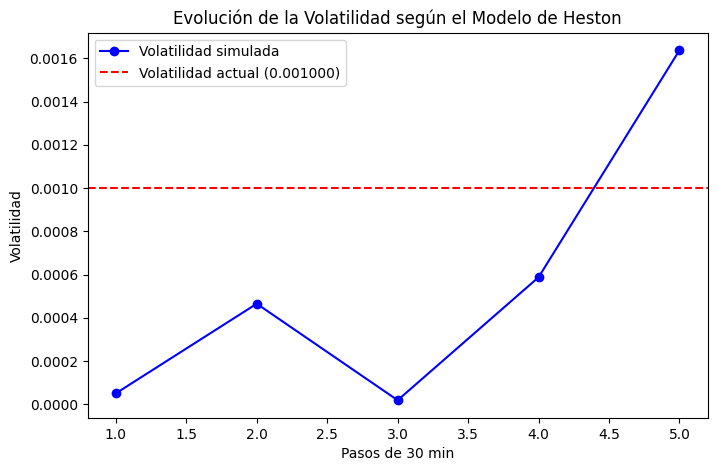

⚠️ Volatilidad en aumento: Mayor incertidumbre en el mercado.


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros del modelo de Heston
mu = 0.000218  # Drift estimado
kappa = 2.0  # Tasa de reversión a la media
theta = 0.0001  # Media de la varianza a largo plazo
sigma = 0.1  # Volatilidad del proceso de volatilidad
v0 = 0.001  # Volatilidad inicial

# Configuración de la simulación
n_steps = 5  # Pasos futuros de 30 min cada uno
v_t = v0  # Volatilidad inicial
simulated_volatility = np.zeros(n_steps)

for t in range(n_steps):
    # Generar ruido gaussiano
    Z = np.random.normal()

    # Evolución de la volatilidad según Heston
    v_t = np.abs(v_t + kappa * (theta - v_t) + sigma * np.sqrt(v_t) * Z)
    simulated_volatility[t] = v_t

# Crear DataFrame con la volatilidad simulada
steps = np.arange(1, n_steps + 1)
df_volatility = pd.DataFrame({
    "Paso": steps,
    "Volatilidad": simulated_volatility
})
df_volatility.set_index("Paso", inplace=True)

# 📌 Graficar la evolución de la volatilidad
plt.figure(figsize=(8,5))
plt.plot(steps, simulated_volatility, marker='o', linestyle='-', color='blue', label="Volatilidad simulada")
plt.axhline(v0, linestyle="dashed", color="red", label=f"Volatilidad actual ({v0:.6f})")
plt.xlabel("Pasos de 30 min")
plt.ylabel("Volatilidad")
plt.title("Evolución de la Volatilidad según el Modelo de Heston")
plt.legend()
plt.show()

# Evaluación de la volatilidad
volatility_trend = "en aumento" if simulated_volatility[-1] > v0 else "en disminución"
print(f"⚠️ Volatilidad {volatility_trend}: {'Mayor incertidumbre en el mercado.' if volatility_trend == 'en aumento' else 'Mercado más estable.'}")


# **FASE 3: Aplicación de Estrategia de Trading**

 Definir Reglas de Entrada y Salida:

**Compra (posición larga)**: Si la LSTM predice un aumento del precio y la mediana del MGBM también es creciente con baja dispersión. Si la volatilidad del modelo de Heston es baja, se confirma la entrada.

**Venta en corto (posición corta):** Si la LSTM predice una caída del precio y la mediana del MGBM también muestra tendencia bajista con baja dispersión. Si la volatilidad es baja, se confirma la entrada en corto. Evitar operar si hay alta dispersión: Si el percentil 5%-95% del MGBM es muy amplio, la incertidumbre es alta y se evita operar.

## **Lógica de Trading Basada en las Predicciones**
1. **Confirmar tendencia con LSTM y MGBM**

  - Compra (posición larga):

     - Si la LSTM predice un aumento en el precio.
    - Si la mediana del MGBM también es creciente.
     - Baja dispersión en MGBM.

     - Baja volatilidad en Heston → Confirmar compra.

  - Venta en corto (posición corta):

    - Si la LSTM predice una bajada del precio.
    - Si la mediana del MGBM también es decreciente.
Baja dispersión en MGBM.
    - Baja volatilidad en Heston → Confirmar venta en corto.
2. **Evitar operar en alta incertidumbre**

- Si la dispersión del MGBM es alta (percentil 95% - percentil 5% > umbral), no operar.

In [125]:



import pandas as pd

# 🔹 Definir umbrales de dispersión y volatilidad para tomar decisiones
umbral_dispersion = 100  # Ajustable según el mercado
umbral_volatilidad = 0.1  # Si la volatilidad supera este valor, hay alta incertidumbre

# 🔹 Extraer la predicción de la LSTM
prediccion_lstm = predicted_price_real  # Precio predicho por la LSTM
ultimo_precio_real = last_real_price  # Último precio real

# 🔹 Obtener la predicción del MGBM
mediana_mgbm = df_predicciones_MGBM["Mediana"]
dispersion_mgbm = df_predicciones_MGBM["Dispersion"]

# 🔹 Obtener la volatilidad estimada del modelo de Heston
volatilidad_heston = simulated_volatility[-1]  # Última volatilidad simulada

# 🔹 Determinar la tendencia del MGBM
if mediana_mgbm.iloc[-1] > ultimo_precio_real:
    tendencia_mgbm = "alcista"
elif mediana_mgbm.iloc[-1] < ultimo_precio_real:
    tendencia_mgbm = "bajista"
else:
    tendencia_mgbm = "neutral"

# 🔹 Evaluar la dispersión
dispersion_alta = dispersion_mgbm.iloc[-1] > umbral_dispersion

# 🔹 Evaluar la volatilidad
volatilidad_alta = volatilidad_heston > umbral_volatilidad

# 📌 📊 **Tomar decisión de trading**
decision = "No operar"  # Default

if prediccion_lstm > ultimo_precio_real and tendencia_mgbm == "alcista" and not dispersion_alta and not volatilidad_alta:
    decision = "Comprar (Posición Larga)"
elif prediccion_lstm < ultimo_precio_real and tendencia_mgbm == "bajista" and not dispersion_alta and not volatilidad_alta:
    decision = "Vender en Corto"
elif dispersion_alta:
    decision = "No operar (Alta Dispersión)"
elif volatilidad_alta:
    decision = "No operar (Alta Volatilidad)"

# 📌 Mostrar resultados
print(f"📌 Último Precio Real: {ultimo_precio_real:.2f}")
print(f"📌 Predicción LSTM: {prediccion_lstm:.2f}")
print(f"📌 Mediana MGBM: {mediana_mgbm.iloc[-1]:.2f}")
print(f"📌 Dispersión MGBM: {dispersion_mgbm.iloc[-1]:.2f}")
print(f"📌 Volatilidad Heston: {volatilidad_heston:.5f}")
print(f"📌 DECISIÓN DE TRADING: {decision}")


📌 Último Precio Real: 202.16
📌 Predicción LSTM: 198.94
📌 Mediana MGBM: 201.96
📌 Dispersión MGBM: 85.16
📌 Volatilidad Heston: 0.00011
📌 DECISIÓN DE TRADING: Vender en Corto


🔹 Compra si:
✅ LSTM predice subida.
✅ MGBM confirma tendencia alcista.
✅ Baja dispersión y baja volatilidad.

🔹 Venta en corto si:
✅ LSTM predice bajada.
✅ MGBM confirma tendencia bajista.
✅ Baja dispersión y baja volatilidad.

🔹 Evitar operar si:
❌ Dispersión del MGBM es alta.
❌ Volatilidad del modelo de Heston es alta.



In [136]:
import pandas as pd

# 🔹 1️⃣ Definir el punto de inicio del backtesting
start_date = "2025-01-31 16:30:00"
df_backtest = df_final_1[df_final_1.index >= start_date]

# 🔹 2️⃣ Reajustar la división de entrenamiento y validación
split = int(len(df_backtest) * 0.8)
df_train = df_backtest.iloc[:split]
df_val = df_backtest.iloc[split:]

# 🔹 3️⃣ Listas para registrar operaciones
trades = []

# 🔹 4️⃣ Definir umbrales de dispersión y volatilidad
umbral_dispersion = 200
umbral_volatilidad = 0.1

# 🔹 5️⃣ Simular decisiones de trading en cada punto del backtesting
for i in range(len(df_val) - 1):  # Se excluye el último dato porque no tiene siguiente precio
    fecha = df_val.index[i]  # Fecha actual en validación
    precio_real = df_val["Close"].iloc[i]  # Precio real en ese momento
    precio_futuro = df_val["Close"].iloc[i + 1]  # Precio real después de 30 minutos
    prediccion_lstm = df_backtest_1_descaled["Precio Predicho"].iloc[i] # Predicción LSTM

    # 🔹 Obtener la predicción del MGBM
    mediana_mgbm = df_predicciones_MGBM["Mediana"].iloc[-1]
    dispersion_mgbm = df_predicciones_MGBM["Dispersion"].iloc[-1]

    # 🔹 Obtener la volatilidad estimada del modelo de Heston
    volatilidad_heston = simulated_volatility[-1]

    # 🔹 Determinar la tendencia del MGBM
    if mediana_mgbm > precio_real:
        tendencia_mgbm = "alcista"
    elif mediana_mgbm < precio_real:
        tendencia_mgbm = "bajista"
    else:
        tendencia_mgbm = "neutral"

    # 🔹 Evaluar si la dispersión o la volatilidad son demasiado altas
    dispersion_alta = dispersion_mgbm > umbral_dispersion
    volatilidad_alta = volatilidad_heston > umbral_volatilidad

    # 📌 📊 **Tomar decisión de trading**
    decision = "No operar"
    ganancia = 0  # Por defecto

    if prediccion_lstm > precio_real and tendencia_mgbm == "alcista" and not dispersion_alta and not volatilidad_alta:
        decision = "Comprar"
        ganancia = precio_futuro - precio_real  # Ganancia de compra

    elif prediccion_lstm < precio_real and tendencia_mgbm == "bajista" and not dispersion_alta and not volatilidad_alta:
        decision = "Vender en Corto"
        ganancia = precio_real - precio_futuro  # Ganancia de venta en corto

    # 🔹 Guardar el trade
    trades.append([fecha, precio_real, precio_futuro, prediccion_lstm, mediana_mgbm, dispersion_mgbm, volatilidad_heston, decision, ganancia])

# 🔹 6️⃣ Convertir resultados a un DataFrame
df_trades = pd.DataFrame(trades, columns=["Fecha", "Precio Entrada", "Precio Salida", "Predicción LSTM", "Mediana MGBM", "Dispersión MGBM", "Volatilidad Heston", "Decisión", "Ganancia"])

# 📌 📊 Evaluación del Rendimiento
total_ganancia = df_trades["Ganancia"].sum()
trades_exitosos = len(df_trades[df_trades["Ganancia"] > 0])
trades_fallidos = len(df_trades[df_trades["Ganancia"] <= 0])
win_rate = trades_exitosos / len(df_trades) if len(df_trades) > 0 else 0

# 📌 📊 Mostrar resultados
df_trades.tail(10)  # Últimos 10 trades
print(f"📌 Total Ganancia Acumulada: {total_ganancia:.2f}")
print(f"📌 Tasa de Éxito: {win_rate:.2%} ({trades_exitosos} exitosos / {len(df_trades)} total)")


📌 Total Ganancia Acumulada: 2.82
📌 Tasa de Éxito: 18.52% (5 exitosos / 27 total)


In [112]:
df_trades

,Fecha,Precio Entrada,Precio Salida,Predicción LSTM,Mediana MGBM,Dispersión MGBM,Volatilidad Heston,Decisión,Ganancia
0,2025-02-04 13:00:00,201.9200,201.9200,202.403707,201.9647,85.163891,0.000111,Comprar,0.0000
1,2025-02-04 13:00:00,201.9200,201.5700,202.467186,201.9647,85.163891,0.000111,Comprar,-0.3500
2,2025-02-04 13:30:00,201.5700,201.5700,202.418752,201.9647,85.163891,0.000111,Comprar,0.0000
3,2025-02-04 13:30:00,201.5700,202.3000,202.362497,201.9647,85.163891,0.000111,Comprar,0.7300
4,2025-02-04 14:00:00,202.3000,202.3000,202.253972,201.9647,85.163891,0.000111,Vender en Corto,0.0000
5,2025-02-04 14:00:00,202.3000,202.1186,202.134319,201.9647,85.163891,0.000111,Vender en Corto,0.1814
6,2025-02-04 14:30:00,202.1186,202.1186,201.879850,201.9647,85.163891,0.000111,Vender en Corto,0.0000
7,2025-02-04 14:30:00,202.1186,201.5797,201.600520,201.9647,85.163891,0.000111,Vender en Corto,0.5389
8,2025-02-04 15:00:00,201.5797,201.5797,201.126312,201.9647,85.163891,0.000111,No operar,0.0000
9,2025-02-04 15:00:00,201.5797,202.1300,200.682489,201.9647,85.163891,0.000111,No operar,0.0000


In [132]:
import pandas as pd

# 🔹 1️⃣ Definir el punto de inicio del backtesting
start_date = "2025-01-31 16:30:00"
df_backtest = df_final_1[df_final_1.index >= start_date]

# 🔹 2️⃣ Reajustar la división de entrenamiento y validación
split = int(len(df_backtest) * 0.8)
df_train = df_backtest.iloc[:split]
df_val = df_backtest.iloc[split:]

# 🔹 3️⃣ Listas para registrar operaciones
trades = []

# 🔹 4️⃣ Definir umbrales de dispersión y volatilidad
umbral_dispersion = 100
umbral_volatilidad = 0.05

# 🔹 5️⃣ Simular decisiones de trading en cada punto del backtesting
for i in range(len(df_val) - 1):  # Se excluye el último dato porque no tiene siguiente precio
    fecha = df_val.index[i]  # Fecha actual en validación
    precio_real = df_val["Close"].iloc[i]  # Precio real en ese momento
    precio_futuro = df_val["Close"].iloc[i + 1]  # Precio real después de 30 minutos
    prediccion_lstm = df_backtest_1_descaled["Precio Predicho"].iloc[i]  # Predicción LSTM

    # 🔹 Obtener la predicción del MGBM
    mediana_mgbm = df_predicciones_MGBM["Mediana"].iloc[-1]
    dispersion_mgbm = df_predicciones_MGBM["Dispersion"].iloc[-1]

    # 🔹 Obtener la volatilidad estimada del modelo de Heston
    volatilidad_heston = simulated_volatility[-1]

    # 🔹 Determinar la tendencia del MGBM
    if mediana_mgbm > precio_real:
        tendencia_mgbm = "alcista"
    elif mediana_mgbm < precio_real:
        tendencia_mgbm = "bajista"
    else:
        tendencia_mgbm = "neutral"

    # 🔹 Evaluar si la dispersión o la volatilidad son demasiado altas
    dispersion_alta = dispersion_mgbm > umbral_dispersion
    volatilidad_alta = volatilidad_heston > umbral_volatilidad

    # 📌 📊 **Tomar decisión de trading**
    decision = "No operar"
    ganancia = 0  # Por defecto

    # 📌 📈 OPERACIÓN EN TENDENCIA ALCISTA
    if prediccion_lstm > precio_real and tendencia_mgbm in ["alcista", "neutral"] and not dispersion_alta and not volatilidad_alta:
        decision = "Comprar"
        ganancia = precio_futuro - precio_real  # Ganancia de compra

    # 📌 📉 OPERACIÓN EN TENDENCIA BAJISTA
    elif prediccion_lstm < precio_real and tendencia_mgbm in ["bajista", "neutral"] and not dispersion_alta and not volatilidad_alta:
        decision = "Vender en Corto"
        ganancia = precio_real - precio_futuro  # Ganancia de venta en corto

    # 🔹 Guardar el trade
    trades.append([fecha, precio_real, precio_futuro, prediccion_lstm, mediana_mgbm, dispersion_mgbm, volatilidad_heston, decision, ganancia])

# 🔹 6️⃣ Convertir resultados a un DataFrame
df_trades_2 = pd.DataFrame(trades, columns=["Fecha", "Precio Entrada", "Precio Salida", "Predicción LSTM", "Mediana MGBM", "Dispersión MGBM", "Volatilidad Heston", "Decisión", "Ganancia"])

# 📌 📊 Evaluación del Rendimiento
total_ganancia = df_trades["Ganancia"].sum()
trades_exitosos = len(df_trades[df_trades["Ganancia"] > 0])
trades_fallidos = len(df_trades[df_trades["Ganancia"] <= 0])
win_rate = trades_exitosos / len(df_trades) if len(df_trades) > 0 else 0

# 📌 📊 Mostrar resultados
df_trades_2  # Últimos 10 trades
print(f"📌 Total Ganancia Acumulada: {total_ganancia:.2f}")
print(f"📌 Tasa de Éxito: {win_rate:.2%} ({trades_exitosos} exitosos / {len(df_trades)} total)")


📌 Total Ganancia Acumulada: 2.82
📌 Tasa de Éxito: 18.52% (5 exitosos / 27 total)


In [114]:
df_trades_2

,Fecha,Precio Entrada,Precio Salida,Predicción LSTM,Mediana MGBM,Dispersión MGBM,Volatilidad Heston,Decisión,Ganancia
0,2025-02-04 13:00:00,201.9200,201.9200,202.403707,201.9647,85.163891,0.000111,Comprar,0.0000
1,2025-02-04 13:00:00,201.9200,201.5700,202.467186,201.9647,85.163891,0.000111,Comprar,-0.3500
2,2025-02-04 13:30:00,201.5700,201.5700,202.418752,201.9647,85.163891,0.000111,Comprar,0.0000
3,2025-02-04 13:30:00,201.5700,202.3000,202.362497,201.9647,85.163891,0.000111,Comprar,0.7300
4,2025-02-04 14:00:00,202.3000,202.3000,202.253972,201.9647,85.163891,0.000111,Vender en Corto,0.0000
5,2025-02-04 14:00:00,202.3000,202.1186,202.134319,201.9647,85.163891,0.000111,Vender en Corto,0.1814
6,2025-02-04 14:30:00,202.1186,202.1186,201.879850,201.9647,85.163891,0.000111,Vender en Corto,0.0000
7,2025-02-04 14:30:00,202.1186,201.5797,201.600520,201.9647,85.163891,0.000111,Vender en Corto,0.5389
8,2025-02-04 15:00:00,201.5797,201.5797,201.126312,201.9647,85.163891,0.000111,No operar,0.0000
9,2025-02-04 15:00:00,201.5797,202.1300,200.682489,201.9647,85.163891,0.000111,No operar,0.0000
